## Lecture 12: Fed-Batch Reactor Simulation
## CHME 5630 - Spring 2020
This notebook goes through the steps involved in simulating a fed-batch reactor, integrating the system of ODE's derived from the material balances. What makes this more difficult than previous examples of numerical integration is that the run is spearated into two parts: the batch, and then the feed. Since we do not know *a priori* when the batch will end, we need our ODE solver to be able to report this. *odeint* is incapable of this, and so we will be using a more recently developed function, **solve_ivp**

Documentation: https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.solve_ivp.html

Structurally, *solve_ivp* is similar to *odeint*, but includes several extra features, including the ability to process *events*. It is this feature we will use to determine when the batch fermentation has ended (by reporting substrate running out), ending the integration for the first phase, and starting the integration of the fed phase.

First, we import the packages we need:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
%matplotlib inline

Next, we'll define the variables we will need, starting with the kinetic and process parameters

In [2]:
mu_max = 0.89 # 1/hr
Ks_glucose = 0.1 #g/L
Ks_oxygen = 0.05 #mmol/L
Y_X_S = 0.4 #gdw/g glucose
Y_X_O2 = 0.1#0.032 #gdw/mmol O2
Q_O2 = 0#19.8 #mmol O2/hr
kLa = 800.0 #1/hr
PO2 = 1.0 #atm
kH = 756.7 #l-atm/mol
C_eq = PO2/kH * 1000.0 #mmol/L
gluc_feed = 100.0 #g/L
feed_rate = 2.0 #l/hr

Now we define our derivative functions (one each for cells, substrate, and O2), which we get from the mass balances,

$$\frac{dX}{dt}=\frac{X(V\mu-\frac{dV}{dt})}{V}$$

$$\frac{dS}{dt}=\frac{FS_{feed}-\frac{XV\mu }{Y_{X/S}}-S\frac{dV}{dt}}{V}$$

$$\frac{dO2}{dt}=\frac{k_La(C_{eq}-O_2)-\frac{XV\mu }{Y_{X/O2}}-XVq_{O2}-O_2\frac{dV}{dt}}{V}$$

Remember that $\mu$ is a function of S and O2, according to:

$$\mu = \mu_{max}\frac{S}{K_S+S}\frac{O_2}{K_S+O_2}$$

We also need to define our feed rate as a piecewise function. Before the initial substrate depletion, there is no feed, and 

$$\frac{dV}{dt}=0$$.

After the substrate is depleted, the pump will be turned on at a constant rate (F), such that 

$$\frac{dV}{dt}=F$$

In [3]:
def deriv(t, y): #Note that, compared to odeint, the dydt function input is reversed as it takes t as the first argument and y as the second
    V = y[0]
    X = y[1]
    S = y[2]
    O2 = y[3]
    
    mu = mu_max * S / (Ks_glucose + S) * O2 / (Ks_oxygen + O2) #Calculate mu once, since it is used in all the balances
    
    F = F_on*feed_rate #F_on is a binary value assigned elsewhere that dictates whether there is feed or not. feed_rate defines the flow rate of the pump when it is turned on
    
    dVdt = F    
    dXdt = (X * V * mu - X * dVdt) / V
    dSdt = (F * gluc_feed - X * V * mu / Y_X_S - S * dVdt) / V
    dO2dt = (kLa* (C_eq - O2) - Q_O2 * X * V - X * V * mu / Y_X_O2 - O2 * dVdt) / V
    
    return dVdt, dXdt, dSdt, dO2dt

The syntax for solve_ivp is similar to odeint, with a couple of major exceptions:

1) The order of arguments is different. The derivative function comes before the time span. 

2) The timespan is just a tuple with a start and end, rather than a defined list of time points

We define one (or more) event functions that the solver will continually monitor. These can be **any** function of y and t, and may or may not lead to termination of the solver.

In [4]:
#Define initial conditions
V0 = 10.0 #L
X0 = 0.2 #g/L
S0 = 20 #g/L
O20 = C_eq
y0 = [V0, X0, S0, O20] #Define our initial conditions

S_threshold = 0.01 #Set the threshold below which it is considered that the reactor has run out of substrate

def out_of_substrate(t, y): return y[2]-S_threshold #Define the event function to find the zeros (e.g. values of t) where y[2]-S_threshold = 0, e.g. the first time point where substrate goes below s_threshold
out_of_substrate.terminal = True #In this case, the event triggers termination of the ode solver. This is optional, and you could have the solver keep going.

#Integrate the ode, triggering termination when substrate hits the pre-determined threshold
F_on = 0.0 #The binary value mentioned earlier for controlling flow
sol = solve_ivp(deriv, (0,5), y0, events=out_of_substrate)


The output from *solve_ivp* looks quite different structurally than from *odeint*. Take a look at all the different data recorded in the sol object that you can later extract:

In [10]:
sol

  message: 'A termination event occurred.'
     nfev: 890
     njev: 0
      nlu: 0
      sol: None
   status: 1
  success: True
        t: array([0.        , 0.02456289, 0.05143214, 0.0890267 , 0.13964845,
       0.18078684, 0.22394944, 0.26711204, 0.30570153, 0.34502703,
       0.38751266, 0.43196765, 0.47085204, 0.51063486, 0.55320127,
       0.59719853, 0.63615954, 0.67593527, 0.71840308, 0.7623147 ,
       0.80138493, 0.8412403 , 0.88364981, 0.92741121, 0.96657293,
       1.00648235, 1.04882844, 1.09246251, 1.13170869, 1.1716697 ,
       1.21395587, 1.25746637, 1.30097688, 1.33779057, 1.37564616,
       1.41864494, 1.46519402, 1.50267252, 1.54157034, 1.58479895,
       1.63029233, 1.66789545, 1.70674027, 1.74975883, 1.79510536,
       1.83290667, 1.87190118, 1.91481169, 1.95985862, 1.99781007,
       2.0368886 , 2.07967774, 2.12448483, 2.16256599, 2.20171985,
       2.24439528, 2.28897235, 2.32715805, 2.36636688, 2.40892923,
       2.45329127, 2.49155693, 2.53080186, 2.57325031, 2

In [ ]:
#Convert the solution to a standard numpy array
np_sol = np.asarray(sol.y)

In [5]:
#Store the time at which the event was triggered
t_out_of_substrate = float(sol.t_events[0])
t_out_of_substrate

4.43595342478025

In [6]:
#Integrate the ODE from the time determined above, now with a feed

init_feed = np_sol[:,-1] #Set the end of the previous simulation as the start point for the next one

F_on = 1.0
sol_feed = solve_ivp(deriv, (t_out_of_substrate,10), init_feed)

In [7]:
#Combine both solutions
np_sol_feed = np.asarray(sol_feed.y)
np_sol_total = np.concatenate((np_sol, np_sol_feed), 1) #Concatenate the two parts of the simulation together
t_feed = sol_feed.t
t_total = np.concatenate((sol.t, t_feed))

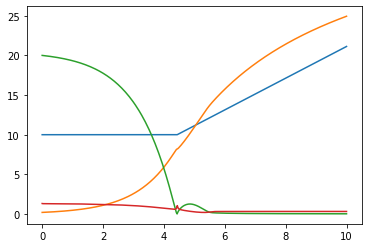

In [12]:
#Plot the data
for i in range (0,4):
    plt.plot(t_total, np_sol_total[i,:])

If we plot the DO concentration independently, we can very clearly see the DO spike typical of a fed-batch reactor

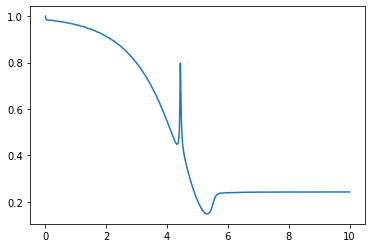

In [9]:
plt.plot(t_total, np_sol_total[3,:]/C_eq)